In [1]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import cluster, metrics

## Clustering stability over time :

To analyse the stability of the clustering over time, we are going 
- to create a kmeans clustering (with k=4 as above) for each 2-month period from 6 monthes ahead of the beginning of the dataset and based on all the orders received to this time
- compare each clustering (on the same unique customers) with the next ones with the adjusted rand score metric
- put each comparison serie into a row of a dataframe and search for the most [appropriate delay x ARI score]

### 1) Creating datasets for each period, processing and kmeans clustering :

In [2]:
# Loading back the full data from the preprocessing notebook :
data_d = pd.read_csv("processed_data.csv")
data_d

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_longitude,customer_latitude,seller_longitude,seller_latitude,day_of_week_purchase,hour_purchase
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,-47.400367,-20.500253,-46.364539,-23.494316,1,15
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,...,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,-46.549350,-23.724844,-48.677675,-26.913214,4,20
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,...,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,-46.656404,-23.531294,-46.364539,-23.494316,5,16
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,...,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,-46.180817,-23.493944,-46.364539,-23.494316,1,16
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,...,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,-47.139272,-22.993053,-48.838906,-21.754867,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,119138,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,...,Recomendo,NaN,2018-04-14 00:00:00,2018-04-28 11:15:04,-46.497362,-23.584362,-49.656367,-22.208468,5,15
119139,119139,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,...,NaN,NaN,2018-04-12 00:00:00,2018-04-16 10:36:05,-46.779405,-23.614720,-48.182883,-21.763230,2,8
119140,119140,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,...,Chateada,Esperava qualidade no atendimento e estou tend...,2018-05-04 00:00:00,2018-05-08 01:41:07,-38.507778,-3.734408,-46.577495,-23.543453,6,20
119141,119141,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,...,NaN,NaN,2017-11-17 00:00:00,2017-11-19 23:34:18,-51.169328,-29.955478,-48.228277,-21.364704,4,21


In [3]:
# Transforming to timestamp format :
data_d['order_purchase_timestamp'] = pd.to_datetime(data_d['order_purchase_timestamp'])

In [4]:
# First date :
first_date = data_d['order_purchase_timestamp'].min()
first_date

Timestamp('2016-09-04 21:15:19')

In [5]:
# 6 monthes after first date :
first_date+datetime.timedelta(days=365.25/2)

Timestamp('2017-03-06 12:15:19')

In [6]:
# Series of timestamps with a 2-month delay between them :

time = first_date
timeserie = [time]
max_date = data_d['order_purchase_timestamp'].max()
print("Most recent date : ", max_date)

while time<max_date:
    time = time+datetime.timedelta(days=(365.25/6))
    timeserie.append(time)

print('')
print("Number of periods in timeserie: ", len(timeserie))
print('')
print(timeserie)

Most recent date :  2018-10-17 17:30:18

Number of periods in timeserie:  14

[Timestamp('2016-09-04 21:15:19'), Timestamp('2016-11-04 18:15:19'), Timestamp('2017-01-04 15:15:19'), Timestamp('2017-03-06 12:15:19'), Timestamp('2017-05-06 09:15:19'), Timestamp('2017-07-06 06:15:19'), Timestamp('2017-09-05 03:15:19'), Timestamp('2017-11-05 00:15:19'), Timestamp('2018-01-04 21:15:19'), Timestamp('2018-03-06 18:15:19'), Timestamp('2018-05-06 15:15:19'), Timestamp('2018-07-06 12:15:19'), Timestamp('2018-09-05 09:15:19'), Timestamp('2018-11-05 06:15:19')]


### Needed transformators from the modelisation notebook :

In [7]:
# Transformer creating the dataframe for kmeans :

class kmeans_selecting_features(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        print("Going through kmeans_preparation")
        print("Shape of data at this point : ", X.shape)
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        
        ## Selecting orders with 'delivered' order_status only :
        X_ = X_[X_['order_status']=="delivered"]
        
        ##Total number of orders :
        d = X_.groupby(by=["customer_unique_id"]).count()
        to_merge_number_orders = pd.DataFrame(data={'customer_unique_id': d.index, 'Total_number_orders': d['order_id']})
            
        ## Mean_price :
        mv = X_.groupby(by=["customer_unique_id"]).mean()
        mv.rename(columns={'price': "Mean_price"}, inplace=True)
        mv = mv[['Mean_price']]
        
        ## Mean_freight_value :
        Mean_freight_value = X_.groupby(by=["customer_unique_id"]).mean()
        Mean_freight_value.rename(columns={'freight_value': "Mean_freight_value"}, inplace=True)
        Mean_freight_value = Mean_freight_value[['Mean_freight_value']]
        
        ## Total_spent :
        ts = X_.groupby(by=["customer_unique_id"]).sum()
        ts.rename(columns={'price': "Total_spent"}, inplace=True)
        ts = ts[['Total_spent']]
        
        ## encoded_review :
        review = X_.groupby(by=["customer_unique_id"]).mean()
        review = review[['review_score']]
        
        review['encoded_review'] = "No review"
        
        review.loc[review.review_score<=2.5, "encoded_review"] = "Bad review"
        review.loc[(review.review_score>2.5), "encoded_review"] = "Good review"
        review.loc[(review.review_score.isna()), "encoded_review"] = "No review"
        
        review.drop(columns=['review_score'], inplace=True)
        
        
        ## Customer_state :
        state = X_.groupby(by=['customer_unique_id']).agg(pd.Series.mode)
        state = state[['customer_state']]
        
        
                
        ## Merging all :
        merged = to_merge_number_orders.drop(columns=['customer_unique_id'])
        merged = merged.merge(mv, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(Mean_freight_value, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(ts, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(review, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        merged = merged.merge(state, how='left', left_on='customer_unique_id', right_on='customer_unique_id')
        
        

        X_ = merged.copy()
        
        # Keep "customer_unique_id" into a column :
        X_['customer_unique_id'] = X_.index
        
        
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)

In [8]:
# Processing :

## Full pipeline :

# CustomSimpleImputer to get feature names out :
class CustomSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy(deep=True)
        if self.strategy=='mean':
            for col in list(X_.columns):
                mean = X_[col].mean()
                X_[col].fillna(mean)
        if self.strategy=='median':
            for col in list(X_.columns):
                median = X_[col].median()
                X_[col].fillna(median)
                                       
        self.features = list(X_.columns)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        feature_names = self.features
        return np.asarray(feature_names, dtype=object)

num_pipeline = Pipeline([('CustomSimpleImputer', CustomSimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])

num_features_to_process = ["Total_number_orders", 
                           "Mean_price", 
                           "Mean_freight_value", 
                           "Total_spent"]

new_pipeline = ColumnTransformer([("num", num_pipeline, num_features_to_process),
                                  ("OHE", OneHotEncoder(), ["encoded_review"]),
                                  ('pass', "passthrough", ["customer_unique_id"])],
                                 sparse_threshold=0)


In [9]:
# Creating the kmeans clusterings :

time_labels = []
unuseful_timestamps = []

for current_date in range(1, len(timeserie)):
    
    # Selection of the data available to a date :
    available_data = data_d[data_d['order_purchase_timestamp']<timeserie[current_date]]
    
    if available_data.shape[0]>20000 : # threshold in number of orders to consider a relevant clustering 

        # Processing available data :
        tf1 = kmeans_selecting_features()
        tf1.fit(available_data)
        processed_available_data = tf1.transform(available_data)

        new_pipeline.fit(processed_available_data)
        processed_data = new_pipeline.transform(processed_available_data)
        
        df = pd.DataFrame(processed_data, columns=new_pipeline.get_feature_names_out())
        useful_for_kmeans = list(df.columns)
        useful_for_kmeans.remove("pass__customer_unique_id")
        array_useful = np.array(df[useful_for_kmeans])

        # kmeans with 4 clusters :
        cls4 = cluster.KMeans(n_clusters=4)
        cls4.fit(array_useful)
        kmeans_labels = cls4.labels_

        # Adding timestamp and labels to time_labels :
        time_labels.append((timeserie[current_date], kmeans_labels, df['pass__customer_unique_id']))
        
    else:
        unuseful_timestamps.append(current_date)
  

Going through kmeans_preparation
Shape of data at this point :  (28907, 47)
Going through kmeans_preparation
Shape of data at this point :  (39731, 47)
Going through kmeans_preparation
Shape of data at this point :  (55812, 47)
Going through kmeans_preparation
Shape of data at this point :  (73394, 47)
Going through kmeans_preparation
Shape of data at this point :  (90240, 47)
Going through kmeans_preparation
Shape of data at this point :  (105446, 47)
Going through kmeans_preparation
Shape of data at this point :  (119127, 47)
Going through kmeans_preparation
Shape of data at this point :  (119143, 47)


In [10]:
time_labels

[(Timestamp('2017-09-05 03:15:19'),
  array([0, 0, 0, ..., 2, 0, 0]),
  0        0000f46a3911fa3c0805444483337064
  1        0005e1862207bf6ccc02e4228effd9a0
  2        0006fdc98a402fceb4eb0ee528f6a8d4
  3        000a5ad9c4601d2bbdd9ed765d5213b3
  4        000de6019bb59f34c099a907c151d855
                         ...               
  22169    fff3a9369e4b7102fab406a334a678c3
  22170    fff699c184bcc967d62fa2c6171765f7
  22171    fffcf5a5ff07b0908bd4e2dbc735a684
  22172    ffff371b4d645b6ecea244b27531430a
  22173    ffffd2657e2aad2907e67c3e9daecbeb
  Name: pass__customer_unique_id, Length: 22174, dtype: object),
 (Timestamp('2017-11-05 00:15:19'),
  array([2, 2, 2, ..., 0, 2, 2]),
  0        0000f46a3911fa3c0805444483337064
  1        0000f6ccb0745a6a4b88665a16c9f078
  2        0005e1862207bf6ccc02e4228effd9a0
  3        0006fdc98a402fceb4eb0ee528f6a8d4
  4        000a5ad9c4601d2bbdd9ed765d5213b3
                         ...               
  30442    fff699c184bcc967d62fa2c6171765f7
  3

In [11]:
# Example to compare clustering from timestamp #1 and timestamp #2 :

# 1st step : check that the labels array and the id dataframe have the same dimensions :
print(time_labels[0][1].shape)
print(time_labels[0][2].shape)

# 2nd step : regroup both into a dataframe :
d1 = pd.concat([pd.DataFrame(time_labels[0][1]), time_labels[0][2]], axis=1)
d1.rename(columns={0: "Cluster 1", "pass__customer_unique_id": "ID"}, inplace=True)
d1.set_index(['ID'], inplace=True)


# 3rd step : redo it for the clustering to compare with :
print(time_labels[1][1].shape)
print(time_labels[1][2].shape)
d2 = pd.concat([pd.DataFrame(time_labels[1][1]), time_labels[1][2]], axis=1)
d2.rename(columns={0: "Cluster 2", "pass__customer_unique_id": "ID"}, inplace=True)
d2.set_index(['ID'], inplace=True)

# 4th step : join both clustering but only for the same ID (which permits to filter the IDs)
d1d2 = d1.join(d2)
print("Shape of joined dataframe : ", d1d2.shape)

# 5th step : process the ARI score :
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(d1d2['Cluster 1'], d1d2['Cluster 2'])

(22174,)
(22174,)
(30447,)
(30447,)
Shape of joined dataframe :  (22174, 2)


0.7231822937761672

In [12]:
# Implementation to compare each clustering at a given timestamps to the following clusterings on the same customers :

every_ARI = []
lenght_labels = []

for clustering_i in range(0, len(time_labels)-1):
    
    ARI_scores = []
    Clusterings = []
    
    
    # Building the reference labels & customers' ID :
    ref_labels = pd.concat([pd.DataFrame(time_labels[clustering_i][1]), time_labels[clustering_i][2]], axis=1)
    name_of_ref_clustering = "Clustering "+str(clustering_i)
    ref_labels.rename(columns={0: name_of_ref_clustering, "pass__customer_unique_id": "ID"}, inplace=True)
    ref_labels.set_index(['ID'], inplace=True)
    
    lenght_labels.append(ref_labels.shape[0])
    
    # Creating the first point of the plot (ARI on itself) :
    ARI_scores.append(adjusted_rand_score(ref_labels[name_of_ref_clustering], ref_labels[name_of_ref_clustering]))
    Clusterings.append(0) # at time t0
    
    # Looking for the labels from the following clusterings for the same customers 
    for clustering_j in range(clustering_i+1, len(time_labels)):
        new_labels = pd.concat([pd.DataFrame(time_labels[clustering_j][1]), time_labels[clustering_j][2]], axis=1)
        name_of_new_clustering = "Clustering "+str(clustering_j)
        new_labels.rename(columns={0: name_of_new_clustering, "pass__customer_unique_id": "ID"}, inplace=True)
        new_labels.set_index(['ID'], inplace=True)
        ref_labels = ref_labels.join(new_labels)
        ARI_scores.append(adjusted_rand_score(ref_labels[name_of_ref_clustering], ref_labels[name_of_new_clustering]))
        Clusterings.append(clustering_j*2-clustering_i*2)
        
    
    every_ARI.append([Clusterings, ARI_scores])   

In [13]:
every_ARI

[[[0, 2, 4, 6, 8, 10, 12, 14],
  [1.0,
   0.7231822937761672,
   0.7752898871238664,
   0.728357496672201,
   0.7349904002109733,
   0.7552096932123291,
   0.758731057266076,
   0.7577704968835962]],
 [[0, 2, 4, 6, 8, 10, 12],
  [1.0,
   0.9200755262109177,
   0.9434260376148619,
   0.9229140306099612,
   0.9036820940907936,
   0.8944866153807851,
   0.8952474253311011]],
 [[0, 2, 4, 6, 8, 10],
  [1.0,
   0.9438669197660956,
   0.9466673893751262,
   0.951509229239411,
   0.9502166397486751,
   0.9508695398898048]],
 [[0, 2, 4, 6, 8],
  [1.0,
   0.9802882502103469,
   0.9414696086104588,
   0.9309081849258043,
   0.9321198481340676]],
 [[0, 2, 4, 6],
  [1.0, 0.960441879342293, 0.9502537580863877, 0.9515790519492695]],
 [[0, 2, 4], [1.0, 0.9886554177495868, 0.9899066292555252]],
 [[0, 2], [1.0, 0.9987932232965365]]]

In [14]:
lenght_labels

[22174, 30447, 43071, 56885, 70218, 82282, 93358]

In [15]:
plot_labels = []
for label in lenght_labels :
    plot_labels.append("Clustering with the same "+str(label)+" customers available at time")
plot_labels

['Clustering with the same 22174 customers available at time',
 'Clustering with the same 30447 customers available at time',
 'Clustering with the same 43071 customers available at time',
 'Clustering with the same 56885 customers available at time',
 'Clustering with the same 70218 customers available at time',
 'Clustering with the same 82282 customers available at time',
 'Clustering with the same 93358 customers available at time']

Text(0.5, 0, 'Monthes since reference clustering')

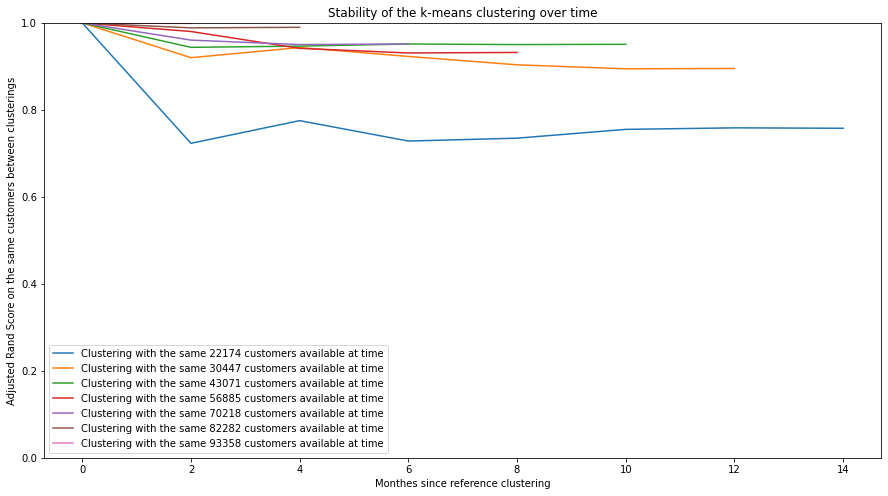

In [16]:
# Plotting the results :

plt.figure(figsize=(15,8))
plt.title("Stability of the k-means clustering over time")
for h in range(len(every_ARI)):
    plt.plot(every_ARI[h][0], every_ARI[h][1], label=plot_labels[h])
plt.legend(loc='best')
plt.ylim([0, 1])
plt.ylabel("Adjusted Rand Score on the same customers between clusterings")
plt.xlabel("Monthes since reference clustering")

#### We can see that the ARI of the clustering is more and more stable with new data (which seems obvious since the amount of data is increasing and not specially the amount of new data between each period).

As the first curve (in blue) shows more variations in amplitude, between the first clustering and 2 monthes after, we are going to compute it again on this period each day :

In [34]:
# Series of timestamps with a 2-month delay between them :

time = first_date
timeserie_2 = [time]
stop_date = time+datetime.timedelta(days=(365))
print("Most recent date : ", stop_date)

while time<stop_date:
    time = time+datetime.timedelta(days=7)
    timeserie_2.append(time)

print('')
print("Number of periods in timeserie: ", len(timeserie_2))
print('')
print(timeserie_2)

Most recent date :  2017-09-04 21:15:19

Number of periods in timeserie:  54

[Timestamp('2016-09-04 21:15:19'), Timestamp('2016-09-11 21:15:19'), Timestamp('2016-09-18 21:15:19'), Timestamp('2016-09-25 21:15:19'), Timestamp('2016-10-02 21:15:19'), Timestamp('2016-10-09 21:15:19'), Timestamp('2016-10-16 21:15:19'), Timestamp('2016-10-23 21:15:19'), Timestamp('2016-10-30 21:15:19'), Timestamp('2016-11-06 21:15:19'), Timestamp('2016-11-13 21:15:19'), Timestamp('2016-11-20 21:15:19'), Timestamp('2016-11-27 21:15:19'), Timestamp('2016-12-04 21:15:19'), Timestamp('2016-12-11 21:15:19'), Timestamp('2016-12-18 21:15:19'), Timestamp('2016-12-25 21:15:19'), Timestamp('2017-01-01 21:15:19'), Timestamp('2017-01-08 21:15:19'), Timestamp('2017-01-15 21:15:19'), Timestamp('2017-01-22 21:15:19'), Timestamp('2017-01-29 21:15:19'), Timestamp('2017-02-05 21:15:19'), Timestamp('2017-02-12 21:15:19'), Timestamp('2017-02-19 21:15:19'), Timestamp('2017-02-26 21:15:19'), Timestamp('2017-03-05 21:15:19'), Tim

In [35]:
# Creating the kmeans clusterings :

time_labels_2 = []
unuseful_timestamps = []
counter_weeks = 0

for current_date in range(1, len(timeserie_2)):
    
    # Selection of the data available to a date :
    available_data = data_d[data_d['order_purchase_timestamp']<timeserie_2[current_date]]
    
    if available_data.shape[0]>20000 : # threshold in number of orders to consider a relevant clustering 

        # Processing available data :
        tf1 = kmeans_selecting_features()
        tf1.fit(available_data)
        processed_available_data = tf1.transform(available_data)

        new_pipeline.fit(processed_available_data)
        processed_data = new_pipeline.transform(processed_available_data)
        
        df = pd.DataFrame(processed_data, columns=new_pipeline.get_feature_names_out())
        useful_for_kmeans = list(df.columns)
        useful_for_kmeans.remove("pass__customer_unique_id")
        array_useful = np.array(df[useful_for_kmeans])

        # kmeans with 4 clusters :
        cls4 = cluster.KMeans(n_clusters=4)
        cls4.fit(array_useful)
        kmeans_labels = cls4.labels_
        
        

        # Adding timestamp and labels to time_labels :
        time_labels_2.append((timeserie_2[current_date], kmeans_labels, df['pass__customer_unique_id']))
        
        counter_weeks = counter_weeks + 1
        
        if counter_weeks > 10:
            break
        
    else:
        unuseful_timestamps.append(current_date)
  

Going through kmeans_preparation
Shape of data at this point :  (20422, 47)
Going through kmeans_preparation
Shape of data at this point :  (21633, 47)
Going through kmeans_preparation
Shape of data at this point :  (22769, 47)
Going through kmeans_preparation
Shape of data at this point :  (23923, 47)
Going through kmeans_preparation
Shape of data at this point :  (25135, 47)
Going through kmeans_preparation
Shape of data at this point :  (26372, 47)
Going through kmeans_preparation
Shape of data at this point :  (27479, 47)
Going through kmeans_preparation
Shape of data at this point :  (28695, 47)
Going through kmeans_preparation
Shape of data at this point :  (29799, 47)


In [36]:
data_d[data_d['order_purchase_timestamp']<timeserie_2[current_date]].shape

(29799, 47)

In [42]:
# Implementation to compare each clustering at a given timestamps to the following clusterings on the same customers :

every_ARI = []
lenght_labels = []

for clustering_i in range(0, len(time_labels)-1):
    
    ARI_scores = []
    Clusterings = []
    
    
    # Building the reference labels & customers' ID :
    ref_labels = pd.concat([pd.DataFrame(time_labels_2[clustering_i][1]), time_labels_2[clustering_i][2]], axis=1)
    name_of_ref_clustering = "Clustering "+str(clustering_i)
    ref_labels.rename(columns={0: name_of_ref_clustering, "pass__customer_unique_id": "ID"}, inplace=True)
    ref_labels.set_index(['ID'], inplace=True)
    
    lenght_labels.append(ref_labels.shape[0])
    
    # Creating the first point of the plot (ARI on itself) :
    ARI_scores.append(adjusted_rand_score(ref_labels[name_of_ref_clustering], ref_labels[name_of_ref_clustering]))
    Clusterings.append(0) # at time t0
    
    # Looking for the labels from the following clusterings for the same customers 
    for clustering_j in range(clustering_i+1, len(time_labels_2)):
        new_labels = pd.concat([pd.DataFrame(time_labels_2[clustering_j][1]), time_labels_2[clustering_j][2]], axis=1)
        name_of_new_clustering = "Clustering "+str(clustering_j)
        new_labels.rename(columns={0: name_of_new_clustering, "pass__customer_unique_id": "ID"}, inplace=True)
        new_labels.set_index(['ID'], inplace=True)
        ref_labels = ref_labels.join(new_labels)
        ARI_scores.append(adjusted_rand_score(ref_labels[name_of_ref_clustering], ref_labels[name_of_new_clustering]))
        Clusterings.append(clustering_j-clustering_i)
        
    
    every_ARI.append([Clusterings, ARI_scores])   

In [43]:
every_ARI[0]

[[0, 1, 2, 3, 4, 5, 6, 7, 8],
 [1.0,
  0.9924749060308756,
  0.9873067056811553,
  0.8819330097780724,
  0.9770363603860596,
  0.8715324292642258,
  0.9619392695235335,
  0.9625881236122259,
  0.8378131673178929]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Weeks since reference clustering')

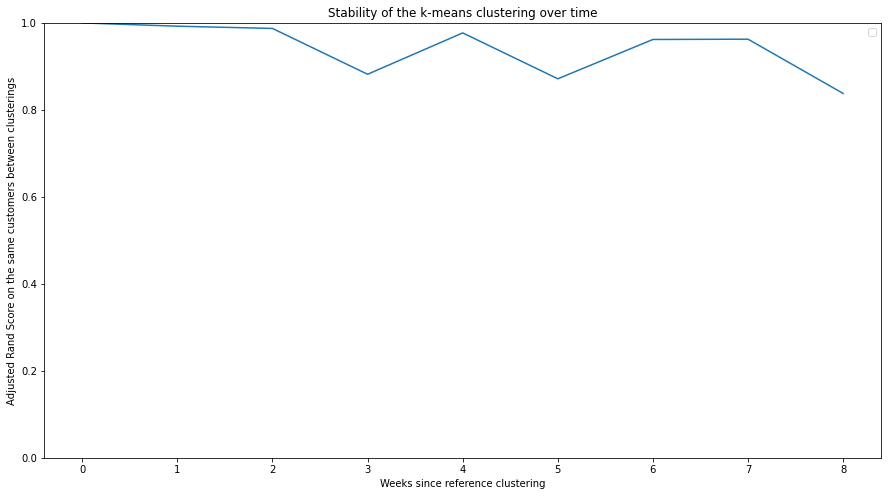

In [45]:
# Plotting the results :

plt.figure(figsize=(15,8))
plt.title("Stability of the k-means clustering over time")
plt.plot(every_ARI[0][0], every_ARI[0][1])
plt.legend(loc='best')
plt.ylim([0, 1])
plt.ylabel("Adjusted Rand Score on the same customers between clusterings")
plt.xlabel("Weeks since reference clustering")